# Sentimentanalyse Projektarbeit - Marketing Analytics HSD SS2023
erstellt von Finn Böckenhoff, Oliver Nolte und David Steinhäuser

In [33]:
import pandas as pd
import numpy as np
import re
import nltk
from emot.emo_unicode import UNICODE_EMOJI, EMOTICONS_EMO
import pickle
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import snscrape
import snscrape.modules.twitter as sntwitter
import datetime
import seaborn as sns

## Read Data

In [34]:
#Read csv file and name columns
data = pd.read_csv("../Data/Twitter.csv", header=None, encoding='latin-1')
data.columns = ['sentiment', 'id', 'date', 'query', 'user', 'tweet']

data.head()

,sentiment,id,date,query,user,tweet
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


## Basic Data Exploration

In [36]:
#Sentiment Distribution
data['sentiment'].value_counts()
# 0 = negative
# 4 = positive

0    800000
4    800000
Name: sentiment, dtype: int64

In [37]:
#Missing Values
data.isna().sum()

sentiment    0
id           0
date         0
query        0
user         0
tweet        0
dtype: int64

In [40]:
#Einfluss Länge von Tweets auf Sentiment
data['num_strings'] = data['tweet'].str.split().str.len()
print(f"Durchschnittliche Anzahl an Strings je Tweet: {data['num_strings'].mean()}")
print(data.groupby('sentiment')['num_strings'].mean())

Durchschnittliche Anzahl an Strings je Tweet: 13.176150625
sentiment
0    13.581984
4    12.770318
Name: num_strings, dtype: float64


<AxesSubplot:xlabel='weekday', ylabel='count'>

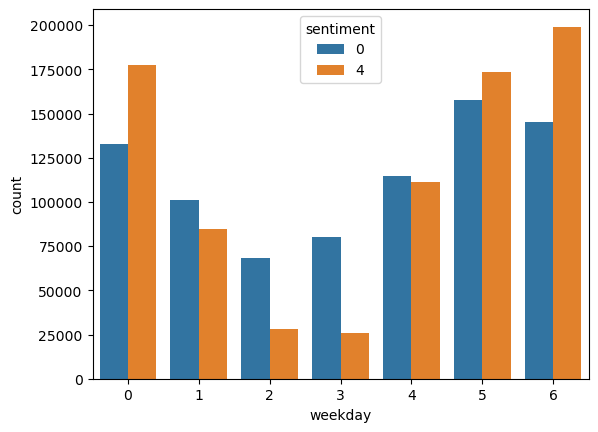

In [41]:
#Create Datetime Column from 'Date', get Weekday from Datetime, check if this has an impact on sentiment
data['date_new'] = data['date'].str[8:10] + "/" + data['date'].str[4:7] + "/" + data['date'].str[24:28] + ", " + data['date'].str[11:19]
data['date_new'] = pd.to_datetime(data['date_new'], format="%d/%b/%Y, %H:%M:%S")

data['weekday'] = pd.DatetimeIndex(data['date_new']).weekday

#Weekday: 0 = Monday, 6 = Sunday
sns.countplot(data=data, x="weekday", hue="sentiment")

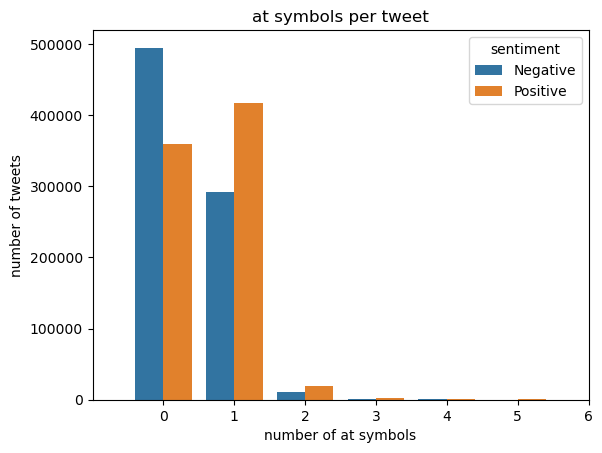

In [47]:
#Einfluss von Verlinkungen '@' auf Sentiment
data['At'] = data['tweet'].str.count('\@')

sns.countplot(data=data, x='At', hue="sentiment")
plt.xlim(-1,6)
plt.title('at symbols per tweet')
plt.xlabel('number of at symbols')
plt.ylabel('number of tweets')
plt.legend(title='sentiment', loc='upper right', labels=['Negative', 'Positive'])

In [50]:
#Count occurance of each word in all Tweets
#Create a list of all words in all tweets
word_list = []
for string in data['tweet']:
    word_list.extend(string.split())

word_counts = {}
for word in word_list:
    if word in word_counts:
        word_counts[word] += 1
    else:
        word_counts[word] = 1

#Sort words by occurance
word_counts = sorted(word_counts.items(), key=lambda x: x[1], reverse=True)
word_counts[0:20]

[('to', 552962),
 ('I', 496619),
 ('the', 487501),
 ('a', 366212),
 ('my', 280025),
 ('and', 275263),
 ('i', 250016),
 ('is', 217693),
 ('you', 213871),
 ('for', 209801),
 ('in', 202294),
 ('of', 179554),
 ('it', 171812),
 ('on', 154365),
 ('have', 132249),
 ('so', 125155),
 ('me', 122509),
 ('that', 118685),
 ('with', 110843),
 ('be', 108069)]

In [54]:
#Word Cloud for negative Tweets
from wordcloud import WordCloud

data_neg = data['tweet'][data['sentiment']==0]
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
               collocations=False).generate(" ".join(data_neg))

plt.imshow(wc)

ValueError: Only supported for TrueType fonts

<Figure size 2000x2000 with 0 Axes>

In [ ]:
#Word Cloud for positive Tweets
data_pos = data['tweet'][data['sentiment']==4]
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
               collocations=False).generate(" ".join(data_pos))
plt.imshow(wc)

## Clean Data

In [3]:
#Drop the column 'query', as it only contains 'NO_QUERY'
data = data.drop(columns= [['query', 'At' 'date_new' 'weekday', 'num_strings']])

#Replace the 4 for a positive sentiment with a 1 for easier understanding (there are no numbers between 0 and 4)
data['sentiment'] = data['sentiment'].replace(4, 1)
#0 = negative, 1 = positive

data.head()

,sentiment,id,date,user,tweet
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,Karoli,"@nationwideclass no, it's not behaving at all...."


In [4]:
#Convert Date and time column into datetime format (By stripping day, month, year and time manually as strings and passing them into datetime function)
data['date_new'] = data['date'].str[8:10] + "/" + data['date'].str[4:7] + "/" + data['date'].str[24:28] + ", " + data['date'].str[11:19]
data['date_new'] = pd.to_datetime(data['date_new'], format="%d/%b/%Y, %H:%M:%S")

#extract DateTime information from column
data['year'] = pd.DatetimeIndex(data['date_new']).year
data['month'] = pd.DatetimeIndex(data['date_new']).month

#Weekday where 0 = Monday and 6 = Sunday
data['weekday'] = pd.DatetimeIndex(data['date_new']).weekday
data['time'] = pd.DatetimeIndex(data['date_new']).time
data['hour'] = pd.DatetimeIndex(data['date_new']).hour

# Extract Timezones
data['date'] = data['date'].astype('string')
data['timezone'] = data['date'].str[20:23]
data.head()

##sort time into groups
#create list of conditions (time groups)
conditions = [
    (data['hour'] < 4),
    (data['hour'] >= 4) & (data['hour'] < 8),
    (data['hour'] >= 8) & (data['hour'] < 12),
    (data['hour'] >= 12) & (data['hour'] < 16),
    (data['hour'] >= 16) & (data['hour'] < 20),
    (data['hour'] >= 20)
    ]

# create a list of the values we want to assign for each condition
values = ['0-4', '4-8', '8-12', '12-16', '16-20', '20-24']

# create a new column and use np.select to assign values to it using our lists as arguments
data['time_group'] = np.select(conditions, values)

#drop old date column
data.drop(['date', 'timezone'], axis = 1, inplace=True)
data.rename(columns={'date_new': 'date'}, inplace=True)

data.head()

,sentiment,id,user,tweet,date,year,month,weekday,time,hour,time_group
0,0,1467810369,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",2009-04-06 22:19:45,2009,4,0,22:19:45,22,20-24
1,0,1467810672,scotthamilton,is upset that he can't update his Facebook by ...,2009-04-06 22:19:49,2009,4,0,22:19:49,22,20-24
2,0,1467810917,mattycus,@Kenichan I dived many times for the ball. Man...,2009-04-06 22:19:53,2009,4,0,22:19:53,22,20-24
3,0,1467811184,ElleCTF,my whole body feels itchy and like its on fire,2009-04-06 22:19:57,2009,4,0,22:19:57,22,20-24
4,0,1467811193,Karoli,"@nationwideclass no, it's not behaving at all....",2009-04-06 22:19:57,2009,4,0,22:19:57,22,20-24


In [5]:
#Count the number of words per tweet
data['word_count'] = data['tweet'].str.split().str.len()

#Check, if certain special characters occur in a tweet (one-hot encoded)
data['dot_dot_dot'] = data['tweet'].str.contains('\.\.\.')
data['exclamation_mark'] = data['tweet'].str.contains('!')
data['question_mark'] = data['tweet'].str.contains('\?')
data['at_symbol'] = data['tweet'].str.contains('\@')
data['link'] = data['tweet'].str.contains('http')
data['money'] = data['tweet'].str.contains('\$|\€|\£')
data['paragraph_symbol'] = data['tweet'].str.contains('\§')
data['hashtag'] = data['tweet'].str.contains('#')

data.head()

,sentiment,id,user,tweet,date,year,month,weekday,time,hour,time_group,word_count,dot_dot_dot,exclamation_mark,question_mark,at_symbol,link,money,paragraph_symbol,hashtag
0,0,1467810369,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",2009-04-06 22:19:45,2009,4,0,22:19:45,22,20-24,19,False,False,False,True,True,False,False,False
1,0,1467810672,scotthamilton,is upset that he can't update his Facebook by ...,2009-04-06 22:19:49,2009,4,0,22:19:49,22,20-24,21,True,True,False,False,False,False,False,False
2,0,1467810917,mattycus,@Kenichan I dived many times for the ball. Man...,2009-04-06 22:19:53,2009,4,0,22:19:53,22,20-24,18,False,False,False,True,False,False,False,False
3,0,1467811184,ElleCTF,my whole body feels itchy and like its on fire,2009-04-06 22:19:57,2009,4,0,22:19:57,22,20-24,10,False,False,False,False,False,False,False,False
4,0,1467811193,Karoli,"@nationwideclass no, it's not behaving at all....",2009-04-06 22:19:57,2009,4,0,22:19:57,22,20-24,21,False,False,True,True,False,False,False,False


In [6]:
convert_dict = {'dot_dot_dot': 'int64',
                'exclamation_mark': 'int64',
                'question_mark': 'int64',
                'at_symbol': 'int64',
                'link': 'int64',
                'money': 'int64',
                'paragraph_symbol': 'int64',
                'hashtag': 'int64'
                }
data = data.astype(convert_dict)

### Prepare Stopwords list (')

In [7]:
nltk.download('stopwords')
stopword = nltk.corpus.stopwords.words('english') #Create a list of english stopwords from nltk
stopword[0:5]

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ollin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


['i', 'me', 'my', 'myself', 'we']

In [8]:
stopword_clean = [word.replace("'", "") for word in stopword]

### URL, #, @, links, emojis

In [9]:
#Define the typical pattern of links ('https://', 'http://', 'www.'), tags ('@') and hashtags ('#')
url_pattern_1 = r'https?://\S+'
url_pattern_2 = r'www\.\S+'
tag_pattern = r'@\S+'
hashtag_pattern = r'#\S+'

#Add a new column for the tokenized tweet and remove all links, tags and hashtags from the tweets
data.insert(4, 'tweet_tokenized', data['tweet'].apply(lambda x: re.sub(url_pattern_1, '', x)))
data['tweet_tokenized'] = data['tweet_tokenized'].apply(lambda x: re.sub(url_pattern_2, '', x))
data['tweet_tokenized'] = data['tweet_tokenized'].apply(lambda x: re.sub(tag_pattern, '', x))
data['tweet_tokenized'] = data['tweet_tokenized'].apply(lambda x: re.sub(hashtag_pattern, '', x))


In [10]:
#Handling Emojis
# Function for converting emojis into word
def convert_emoticons(text):
    for emot in EMOTICONS_EMO:
        text = text.replace(emot, "".join(EMOTICONS_EMO[emot].replace(",","").replace(":","").split()))
    return text

# Apply Formula to tweets
data['tweet_tokenized'] = data['tweet_tokenized'].apply(lambda x: convert_emoticons(x))
data.head(6)

,sentiment,id,user,tweet,tweet_tokenized,date,year,month,weekday,time,...,time_group,word_count,dot_dot_dot,exclamation_mark,question_mark,at_symbol,link,money,paragraph_symbol,hashtag
0,0,1467810369,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t...","- Awww, that's a bummer. You shoulda got Da...",2009-04-06 22:19:45,2009,4,0,22:19:45,...,20-24,19,0,0,0,1,1,0,0,0
1,0,1467810672,scotthamilton,is upset that he can't update his Facebook by ...,is upset that he can't update his Facebook by ...,2009-04-06 22:19:49,2009,4,0,22:19:49,...,20-24,21,1,1,0,0,0,0,0,0
2,0,1467810917,mattycus,@Kenichan I dived many times for the ball. Man...,I dived many times for the ball. Managed to s...,2009-04-06 22:19:53,2009,4,0,22:19:53,...,20-24,18,0,0,0,1,0,0,0,0
3,0,1467811184,ElleCTF,my whole body feels itchy and like its on fire,my whole body feels itchy and like its on fire,2009-04-06 22:19:57,2009,4,0,22:19:57,...,20-24,10,0,0,0,0,0,0,0,0
4,0,1467811193,Karoli,"@nationwideclass no, it's not behaving at all....","no, it's not behaving at all. i'm mad. why am...",2009-04-06 22:19:57,2009,4,0,22:19:57,...,20-24,21,0,0,1,1,0,0,0,0
5,0,1467811372,joy_wolf,@Kwesidei not the whole crew,not the whole crew,2009-04-06 22:20:00,2009,4,0,22:20:00,...,20-24,5,0,0,0,1,0,0,0,0


### Punctuation, Whitespace, Lowercase, Numbers

In [11]:
#Remove all punctuation from the tweets
data['tweet_tokenized'] = data['tweet_tokenized'].str.replace('[^\w\s]', ' ')
data['tweet_tokenized'] = data['tweet_tokenized'].str.replace('_', '')

#Remove all whitespaces from the beginning or end of the tweets
data['tweet_tokenized'] = data['tweet_tokenized'].str.strip()

#Set all characters to lowercase
data['tweet_tokenized'] = data['tweet_tokenized'].apply(lambda x: x.lower())

#Remove all numbers
data['tweet_tokenized'] = data['tweet_tokenized'].str.replace('\d+', '')

data.head()

C:\Users\ollin\AppData\Local\Temp\ipykernel_5920\1343740076.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  data['tweet_tokenized'] = data['tweet_tokenized'].str.replace('[^\w\s]', ' ')
C:\Users\ollin\AppData\Local\Temp\ipykernel_5920\1343740076.py:12: FutureWarning: The default value of regex will change from True to False in a future version.
  data['tweet_tokenized'] = data['tweet_tokenized'].str.replace('\d+', '')


,sentiment,id,user,tweet,tweet_tokenized,date,year,month,weekday,time,...,time_group,word_count,dot_dot_dot,exclamation_mark,question_mark,at_symbol,link,money,paragraph_symbol,hashtag
0,0,1467810369,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",awww that s a bummer you shoulda got david ...,2009-04-06 22:19:45,2009,4,0,22:19:45,...,20-24,19,0,0,0,1,1,0,0,0
1,0,1467810672,scotthamilton,is upset that he can't update his Facebook by ...,is upset that he can t update his facebook by ...,2009-04-06 22:19:49,2009,4,0,22:19:49,...,20-24,21,1,1,0,0,0,0,0,0
2,0,1467810917,mattycus,@Kenichan I dived many times for the ball. Man...,i dived many times for the ball managed to sa...,2009-04-06 22:19:53,2009,4,0,22:19:53,...,20-24,18,0,0,0,1,0,0,0,0
3,0,1467811184,ElleCTF,my whole body feels itchy and like its on fire,my whole body feels itchy and like its on fire,2009-04-06 22:19:57,2009,4,0,22:19:57,...,20-24,10,0,0,0,0,0,0,0,0
4,0,1467811193,Karoli,"@nationwideclass no, it's not behaving at all....",no it s not behaving at all i m mad why am ...,2009-04-06 22:19:57,2009,4,0,22:19:57,...,20-24,21,0,0,1,1,0,0,0,0


### Tokenizing

In [12]:
#Tokenize sentences based on non-alphanumeric characters (Leerstelle)
def tokenize(text):
    tokens = re.split('\W+', text)
    return tokens

data['tweet_tokenized'] = data['tweet_tokenized'].apply(lambda x: tokenize(x))

data.head()

,sentiment,id,user,tweet,tweet_tokenized,date,year,month,weekday,time,...,time_group,word_count,dot_dot_dot,exclamation_mark,question_mark,at_symbol,link,money,paragraph_symbol,hashtag
0,0,1467810369,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t...","[awww, that, s, a, bummer, you, shoulda, got, ...",2009-04-06 22:19:45,2009,4,0,22:19:45,...,20-24,19,0,0,0,1,1,0,0,0
1,0,1467810672,scotthamilton,is upset that he can't update his Facebook by ...,"[is, upset, that, he, can, t, update, his, fac...",2009-04-06 22:19:49,2009,4,0,22:19:49,...,20-24,21,1,1,0,0,0,0,0,0
2,0,1467810917,mattycus,@Kenichan I dived many times for the ball. Man...,"[i, dived, many, times, for, the, ball, manage...",2009-04-06 22:19:53,2009,4,0,22:19:53,...,20-24,18,0,0,0,1,0,0,0,0
3,0,1467811184,ElleCTF,my whole body feels itchy and like its on fire,"[my, whole, body, feels, itchy, and, like, its...",2009-04-06 22:19:57,2009,4,0,22:19:57,...,20-24,10,0,0,0,0,0,0,0,0
4,0,1467811193,Karoli,"@nationwideclass no, it's not behaving at all....","[no, it, s, not, behaving, at, all, i, m, mad,...",2009-04-06 22:19:57,2009,4,0,22:19:57,...,20-24,21,0,0,1,1,0,0,0,0


### Remove Stopwords

In [13]:
def remove_stopwords(tokenized_list): #Function to remove all stopword from our list of tokenized tweets
    text = [word for word in tokenized_list if word not in stopword_clean] #Write each word from our tokenized list into a new list, if it is not in the stopword list
    return text

#Create new column with tokenized tweets without stopwords
data['tweet_tokenized'] = data['tweet_tokenized'].apply(lambda x: remove_stopwords(x)) 
data.head()

,sentiment,id,user,tweet,tweet_tokenized,date,year,month,weekday,time,...,time_group,word_count,dot_dot_dot,exclamation_mark,question_mark,at_symbol,link,money,paragraph_symbol,hashtag
0,0,1467810369,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t...","[awww, bummer, shoulda, got, david, carr, thir...",2009-04-06 22:19:45,2009,4,0,22:19:45,...,20-24,19,0,0,0,1,1,0,0,0
1,0,1467810672,scotthamilton,is upset that he can't update his Facebook by ...,"[upset, update, facebook, texting, might, cry,...",2009-04-06 22:19:49,2009,4,0,22:19:49,...,20-24,21,1,1,0,0,0,0,0,0
2,0,1467810917,mattycus,@Kenichan I dived many times for the ball. Man...,"[dived, many, times, ball, managed, save, rest...",2009-04-06 22:19:53,2009,4,0,22:19:53,...,20-24,18,0,0,0,1,0,0,0,0
3,0,1467811184,ElleCTF,my whole body feels itchy and like its on fire,"[whole, body, feels, itchy, like, fire]",2009-04-06 22:19:57,2009,4,0,22:19:57,...,20-24,10,0,0,0,0,0,0,0,0
4,0,1467811193,Karoli,"@nationwideclass no, it's not behaving at all....","[behaving, mad, see]",2009-04-06 22:19:57,2009,4,0,22:19:57,...,20-24,21,0,0,1,1,0,0,0,0


### Lemmatizing

In [14]:
#nltk.download('wordnet')
wnlemm = nltk.WordNetLemmatizer() 

def lemmatizing(tokenized_text): #Function to lemmatize all words in our tokenized tweets list without stopwords
    text = [wnlemm.lemmatize(word) for word in tokenized_text] #Lemmatize each word in our tokenized list and write it into a new list
    return text

#Create new column with lemmatized tweets from our tokenized tweets without stopwords
data['tweet_tokenized'] = data['tweet_tokenized'].apply(lambda x: lemmatizing(x))
data.head()

,sentiment,id,user,tweet,tweet_tokenized,date,year,month,weekday,time,...,time_group,word_count,dot_dot_dot,exclamation_mark,question_mark,at_symbol,link,money,paragraph_symbol,hashtag
0,0,1467810369,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t...","[awww, bummer, shoulda, got, david, carr, thir...",2009-04-06 22:19:45,2009,4,0,22:19:45,...,20-24,19,0,0,0,1,1,0,0,0
1,0,1467810672,scotthamilton,is upset that he can't update his Facebook by ...,"[upset, update, facebook, texting, might, cry,...",2009-04-06 22:19:49,2009,4,0,22:19:49,...,20-24,21,1,1,0,0,0,0,0,0
2,0,1467810917,mattycus,@Kenichan I dived many times for the ball. Man...,"[dived, many, time, ball, managed, save, rest,...",2009-04-06 22:19:53,2009,4,0,22:19:53,...,20-24,18,0,0,0,1,0,0,0,0
3,0,1467811184,ElleCTF,my whole body feels itchy and like its on fire,"[whole, body, feel, itchy, like, fire]",2009-04-06 22:19:57,2009,4,0,22:19:57,...,20-24,10,0,0,0,0,0,0,0,0
4,0,1467811193,Karoli,"@nationwideclass no, it's not behaving at all....","[behaving, mad, see]",2009-04-06 22:19:57,2009,4,0,22:19:57,...,20-24,21,0,0,1,1,0,0,0,0


### Convert Tokenized List to String for Cleaning

In [15]:
#N-gram vectorizing and tfidf need a list of strings passed to it, so we need to convert our list
data['tweet_tokenized_string'] = data['tweet_tokenized'].apply(lambda x: ' '.join(x)) #Join each word in our list with a space inbetween
data

,sentiment,id,user,tweet,tweet_tokenized,date,year,month,weekday,time,...,word_count,dot_dot_dot,exclamation_mark,question_mark,at_symbol,link,money,paragraph_symbol,hashtag,tweet_tokenized_string
0,0,1467810369,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t...","[awww, bummer, shoulda, got, david, carr, thir...",2009-04-06 22:19:45,2009,4,0,22:19:45,...,19,0,0,0,1,1,0,0,0,awww bummer shoulda got david carr third day w...
1,0,1467810672,scotthamilton,is upset that he can't update his Facebook by ...,"[upset, update, facebook, texting, might, cry,...",2009-04-06 22:19:49,2009,4,0,22:19:49,...,21,1,1,0,0,0,0,0,0,upset update facebook texting might cry result...
2,0,1467810917,mattycus,@Kenichan I dived many times for the ball. Man...,"[dived, many, time, ball, managed, save, rest,...",2009-04-06 22:19:53,2009,4,0,22:19:53,...,18,0,0,0,1,0,0,0,0,dived many time ball managed save rest go bound
3,0,1467811184,ElleCTF,my whole body feels itchy and like its on fire,"[whole, body, feel, itchy, like, fire]",2009-04-06 22:19:57,2009,4,0,22:19:57,...,10,0,0,0,0,0,0,0,0,whole body feel itchy like fire
4,0,1467811193,Karoli,"@nationwideclass no, it's not behaving at all....","[behaving, mad, see]",2009-04-06 22:19:57,2009,4,0,22:19:57,...,21,0,0,1,1,0,0,0,0,behaving mad see
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1599995,1,2193601966,AmandaMarie1028,Just woke up. Having no school is the best fee...,"[woke, school, best, feeling, ever]",2009-06-16 08:40:49,2009,6,1,08:40:49,...,11,0,0,0,0,0,0,0,0,woke school best feeling ever
1599996,1,2193601969,TheWDBoards,TheWDB.com - Very cool to hear old Walt interv...,"[thewdb, com, cool, hear, old, walt, interview...",2009-06-16 08:40:49,2009,6,1,08:40:49,...,11,0,1,0,0,1,0,0,0,thewdb com cool hear old walt interview â
1599997,1,2193601991,bpbabe,Are you ready for your MoJo Makeover? Ask me f...,"[ready, mojo, makeover, ask, detail]",2009-06-16 08:40:49,2009,6,1,08:40:49,...,11,0,0,1,0,0,0,0,0,ready mojo makeover ask detail
1599998,1,2193602064,tinydiamondz,Happy 38th Birthday to my boo of alll time!!! ...,"[happy, th, birthday, boo, alll, time, tupac, ...",2009-06-16 08:40:49,2009,6,1,08:40:49,...,12,0,1,0,0,0,0,0,0,happy th birthday boo alll time tupac amaru sh...


### Delete Words that appear less than 5 times

In [16]:
words = pd.DataFrame(data.tweet_tokenized_string.str.split(expand=True).stack().value_counts()).reset_index()
words.rename(columns={'index': 'word', 0: 'count'}, inplace=True)

In [17]:
words_to_split = words[words['count'] < 5]
words_to_split

,word,count
46803,uptodate,4
46804,doinnnn,4
46805,landd,4
46806,emilee,4
46807,posole,4
...,...,...
255177,aaaai,1
255178,mã³,1
255179,shoguets,1
255180,huashiasuhisauhisauhsia,1


In [18]:
words_to_split_list = words_to_split['word'].tolist()
words_to_split_list

['uptodate',
 'doinnnn',
 'landd',
 'emilee',
 'posole',
 'sympathizes',
 'undang',
 'idisk',
 'annddd',
 'fagioli',
 'vedem',
 'clownin',
 'tryign',
 'porfavor',
 'ikan',
 'backbooth',
 'waitaminute',
 'applegate',
 'foulest',
 'readiness',
 'grasped',
 'hahahhahaa',
 'puce',
 'chictopia',
 'guuud',
 'zwart',
 'baaaddd',
 'proffessional',
 'souf',
 'airstream',
 'yurs',
 'myah',
 'nakakaiyak',
 'isbn',
 'extender',
 'swo',
 'venga',
 'chak',
 'perish',
 'marcelo',
 'kessel',
 'nighs',
 'cafetaria',
 'fulbright',
 'boreeedd',
 'kitonguestickingoutcheekyplayfulorblowingaraspberry',
 'youuuuuuuuuuuuuu',
 'aaall',
 'balita',
 'slowin',
 'geographie',
 'subwayyy',
 'twitterstream',
 'wicca',
 'dawanda',
 'playwright',
 'xiaxue',
 'booz',
 'cheesesticks',
 'clinically',
 'heeeeere',
 'ppi',
 'snuffing',
 'ghat',
 'balikan',
 'rdg',
 'lep',
 'partisan',
 'armm',
 'taxman',
 'relativism',
 'catskills',
 'gonnae',
 'mmsskepticalannoyedundecideduneasyorhesitant',
 'hth',
 'citipointe',
 'regen'

In [19]:
single_use_words = set(words_to_split_list) # Convert your list to a set for faster lookup

def remove_single_use_words(tweet):
    return [word for word in tweet if word not in single_use_words]

data['tweet_tokenized'] = data['tweet_tokenized'].apply(remove_single_use_words)

### Convert Tokenized List to String for Vectorizing

In [20]:
#N-gram vectorizing and tfidf need a list of strings passed to it, so we need to convert our list
data['tweet_tokenized_string'] = data['tweet_tokenized'].apply(lambda x: ' '.join(x)) #Join each word in our list with a space inbetween
data

,sentiment,id,user,tweet,tweet_tokenized,date,year,month,weekday,time,...,word_count,dot_dot_dot,exclamation_mark,question_mark,at_symbol,link,money,paragraph_symbol,hashtag,tweet_tokenized_string
0,0,1467810369,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t...","[awww, bummer, shoulda, got, david, carr, thir...",2009-04-06 22:19:45,2009,4,0,22:19:45,...,19,0,0,0,1,1,0,0,0,awww bummer shoulda got david carr third day w...
1,0,1467810672,scotthamilton,is upset that he can't update his Facebook by ...,"[upset, update, facebook, texting, might, cry,...",2009-04-06 22:19:49,2009,4,0,22:19:49,...,21,1,1,0,0,0,0,0,0,upset update facebook texting might cry result...
2,0,1467810917,mattycus,@Kenichan I dived many times for the ball. Man...,"[many, time, ball, managed, save, rest, go, bo...",2009-04-06 22:19:53,2009,4,0,22:19:53,...,18,0,0,0,1,0,0,0,0,many time ball managed save rest go bound
3,0,1467811184,ElleCTF,my whole body feels itchy and like its on fire,"[whole, body, feel, itchy, like, fire]",2009-04-06 22:19:57,2009,4,0,22:19:57,...,10,0,0,0,0,0,0,0,0,whole body feel itchy like fire
4,0,1467811193,Karoli,"@nationwideclass no, it's not behaving at all....","[behaving, mad, see]",2009-04-06 22:19:57,2009,4,0,22:19:57,...,21,0,0,1,1,0,0,0,0,behaving mad see
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1599995,1,2193601966,AmandaMarie1028,Just woke up. Having no school is the best fee...,"[woke, school, best, feeling, ever]",2009-06-16 08:40:49,2009,6,1,08:40:49,...,11,0,0,0,0,0,0,0,0,woke school best feeling ever
1599996,1,2193601969,TheWDBoards,TheWDB.com - Very cool to hear old Walt interv...,"[com, cool, hear, old, walt, interview, â]",2009-06-16 08:40:49,2009,6,1,08:40:49,...,11,0,1,0,0,1,0,0,0,com cool hear old walt interview â
1599997,1,2193601991,bpbabe,Are you ready for your MoJo Makeover? Ask me f...,"[ready, mojo, makeover, ask, detail]",2009-06-16 08:40:49,2009,6,1,08:40:49,...,11,0,0,1,0,0,0,0,0,ready mojo makeover ask detail
1599998,1,2193602064,tinydiamondz,Happy 38th Birthday to my boo of alll time!!! ...,"[happy, th, birthday, boo, alll, time, tupac, ...",2009-06-16 08:40:49,2009,6,1,08:40:49,...,12,0,1,0,0,0,0,0,0,happy th birthday boo alll time tupac shakur


### Tweets rausfiltern, die keine Buchstaben des Alphabets beinhalten

In [21]:
data = data[data['tweet_tokenized_string'].str.contains('[a-zA-Z]')==True] # Alle Tweet herausfiltern die nur nicht normale Buchstaben enthalten

In [22]:
# Index resetten um ihn neu zu nummerieren da sich die Anzahl der Tweets geändert hat
data = data.reset_index()
data

,index,sentiment,id,user,tweet,tweet_tokenized,date,year,month,weekday,...,word_count,dot_dot_dot,exclamation_mark,question_mark,at_symbol,link,money,paragraph_symbol,hashtag,tweet_tokenized_string
0,0,0,1467810369,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t...","[awww, bummer, shoulda, got, david, carr, thir...",2009-04-06 22:19:45,2009,4,0,...,19,0,0,0,1,1,0,0,0,awww bummer shoulda got david carr third day w...
1,1,0,1467810672,scotthamilton,is upset that he can't update his Facebook by ...,"[upset, update, facebook, texting, might, cry,...",2009-04-06 22:19:49,2009,4,0,...,21,1,1,0,0,0,0,0,0,upset update facebook texting might cry result...
2,2,0,1467810917,mattycus,@Kenichan I dived many times for the ball. Man...,"[many, time, ball, managed, save, rest, go, bo...",2009-04-06 22:19:53,2009,4,0,...,18,0,0,0,1,0,0,0,0,many time ball managed save rest go bound
3,3,0,1467811184,ElleCTF,my whole body feels itchy and like its on fire,"[whole, body, feel, itchy, like, fire]",2009-04-06 22:19:57,2009,4,0,...,10,0,0,0,0,0,0,0,0,whole body feel itchy like fire
4,4,0,1467811193,Karoli,"@nationwideclass no, it's not behaving at all....","[behaving, mad, see]",2009-04-06 22:19:57,2009,4,0,...,21,0,0,1,1,0,0,0,0,behaving mad see
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1588294,1599995,1,2193601966,AmandaMarie1028,Just woke up. Having no school is the best fee...,"[woke, school, best, feeling, ever]",2009-06-16 08:40:49,2009,6,1,...,11,0,0,0,0,0,0,0,0,woke school best feeling ever
1588295,1599996,1,2193601969,TheWDBoards,TheWDB.com - Very cool to hear old Walt interv...,"[com, cool, hear, old, walt, interview, â]",2009-06-16 08:40:49,2009,6,1,...,11,0,1,0,0,1,0,0,0,com cool hear old walt interview â
1588296,1599997,1,2193601991,bpbabe,Are you ready for your MoJo Makeover? Ask me f...,"[ready, mojo, makeover, ask, detail]",2009-06-16 08:40:49,2009,6,1,...,11,0,0,1,0,0,0,0,0,ready mojo makeover ask detail
1588297,1599998,1,2193602064,tinydiamondz,Happy 38th Birthday to my boo of alll time!!! ...,"[happy, th, birthday, boo, alll, time, tupac, ...",2009-06-16 08:40:49,2009,6,1,...,12,0,1,0,0,0,0,0,0,happy th birthday boo alll time tupac shakur


## Model Building

### Train Test Split

In [23]:
data.drop(columns=['index', 'id', 'user', 'tweet', 'tweet_tokenized', 'date', 'year', 'month', 'time', 'time_group'], axis = 1, inplace = True)

In [24]:
#Split data in Dependent and indepentent variable
X = data.drop(columns=['sentiment'], axis = 1)
y= data['sentiment']

In [25]:
#Train/Test Split into 3 sets (Training, Validation and Test)
from sklearn.model_selection import train_test_split

X_train, X_validation_and_test, y_train, y_validation_and_test = train_test_split(X, y, test_size=.1, random_state=42)
X_validation, X_test, y_validation, y_test = train_test_split(X_validation_and_test, y_validation_and_test, test_size=.1, random_state = 42)


In [26]:
print ("Train set has total {0} entries with {1:.2f}% negative, {2:.2f}% positive".format(len(X_train),
    (len(X_train[y_train == 0]) / (len(X_train)*1.))*100,
    (len(X_train[y_train == 1]) / (len(X_train)*1.))*100))
print("Validation set has total {0} entries with {1:.2f}% negative, {2:.2f}% positive".format(len(X_validation),
    (len(X_validation[y_validation == 0]) / (len(X_validation)*1.))*100,
    (len(X_validation[y_validation == 1]) / (len(X_validation)*1.))*100))
print("Test set has total {0} entries with {1:.2f}% negative, {2:.2f}% positive".format(len(X_test),
    (len(X_test[y_test == 0]) / (len(X_test)*1.))*100,
    (len(X_test[y_test == 1]) / (len(X_test)*1.))*100))

Train set has total 1429469 entries with 50.08% negative, 49.92% positive
Validation set has total 142947 entries with 49.72% negative, 50.28% positive
Test set has total 15883 entries with 49.12% negative, 50.88% positive


### 1. Base Model - TextBlob (Used as a benchmark for our Accuracy Score)

In [27]:
#Set Baseline for comparison of Our Model
#Use Textblob (Pre-Trained Model, in which you only feed the strings)
from textblob import TextBlob
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

#Create DF to only feed in strings without any extra features
X_validation_strings = X_validation[ 'tweet_tokenized_string']


tbresult = [TextBlob(i).sentiment.polarity for i in X_validation_strings]
tbpred = [0 if n < 0 else 1 for n in tbresult]

In [28]:
conmat = np.array(confusion_matrix(y_validation, tbpred, labels=[1,0]))

confusion = pd.DataFrame(conmat, index=['positive', 'negative'],
                         columns=['predicted_positive','predicted_negative'])

print ("Accuracy Score: {0:.2f}%".format(accuracy_score(y_validation, tbpred)*100))
print ("-"*80)
print ("Confusion Matrix\n")
print (confusion)

Accuracy Score: 60.35%
--------------------------------------------------------------------------------
Confusion Matrix

          predicted_positive  predicted_negative
positive               65207                6661
negative               50023               21056


In [29]:
def accuracy_summary(pipeline, x_train, y_train, x_test, y_test):

    sentiment_fit = pipeline.fit(x_train, y_train)
    y_pred = sentiment_fit.predict(x_test)
    accuracy = accuracy_score(y_test, y_pred)
    print("accuracy score: {0:.2f}%".format(accuracy*100))
    print("-"*80)
    return accuracy

### 2. Linear Regression Count Vectorizer

In [30]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
import scipy
from scipy.sparse import hstack

cvec = CountVectorizer()
lr = LogisticRegression(random_state = 42)
n_features = np.arange(10000,100001,10000)

add_features_train = X_train[['weekday','hour','word_count','dot_dot_dot','exclamation_mark','question_mark','at_symbol','link','money','paragraph_symbol','hashtag']]
add_features_test = X_test[['weekday','hour','word_count','dot_dot_dot','exclamation_mark','question_mark','at_symbol','link','money','paragraph_symbol','hashtag']]


for n in n_features:

    #Initialise Vectoriser in loop
    cvec = CountVectorizer(max_features=n)

    #Vectorize String
    X_train_matrix = cvec.fit_transform(X_train['tweet_tokenized_string'])
    X_test_matrix = cvec.transform(X_test['tweet_tokenized_string'])

    # We convert the additional_features dataframe to a sparse matrix
    add_features_train_matrix = scipy.sparse.csr_matrix(add_features_train.values)
    add_features_test_matrix = scipy.sparse.csr_matrix(add_features_test.values)

    # Then we horizontally stack the tf-idf matrix with the additional features
    X_train_matrix = hstack([X_train_matrix, add_features_train_matrix])
    X_test_matrix = hstack([X_test_matrix, add_features_test_matrix])

    #fit(train) model
    lr.fit(X_train_matrix, y_train)
    y_pred = lr.predict(X_test_matrix)

    accuracy = accuracy_score(y_test, y_pred)
    print ("accuracy score: {0:.2f}%".format(accuracy*100))
    print ("-"*80)


c:\Users\ollin\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


accuracy score: 75.57%
--------------------------------------------------------------------------------


c:\Users\ollin\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


accuracy score: 74.85%
--------------------------------------------------------------------------------


c:\Users\ollin\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


accuracy score: 75.54%
--------------------------------------------------------------------------------


c:\Users\ollin\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


accuracy score: 75.64%
--------------------------------------------------------------------------------


c:\Users\ollin\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


accuracy score: 75.53%
--------------------------------------------------------------------------------


c:\Users\ollin\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


accuracy score: 74.68%
--------------------------------------------------------------------------------


c:\Users\ollin\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


accuracy score: 74.68%
--------------------------------------------------------------------------------


c:\Users\ollin\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


accuracy score: 74.68%
--------------------------------------------------------------------------------


c:\Users\ollin\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


accuracy score: 74.68%
--------------------------------------------------------------------------------
accuracy score: 74.68%
--------------------------------------------------------------------------------


c:\Users\ollin\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


c:\Users\ollin\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\ollin\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

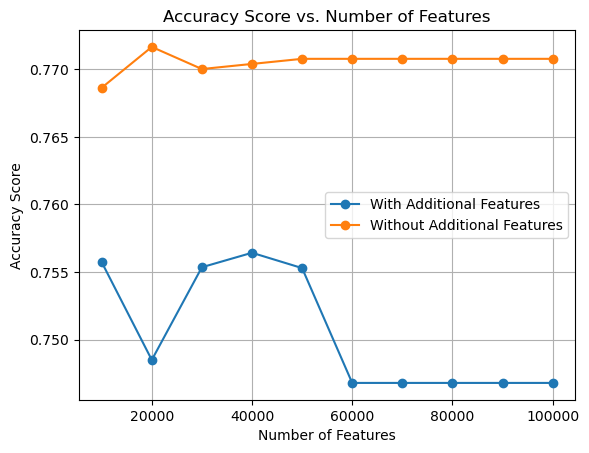

In [31]:
#Accuracy with/without own features

import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from scipy.sparse import hstack

# Create CountVectorizer and LogisticRegression
cvec = CountVectorizer()
lr = LogisticRegression(random_state=42)

# Define values for n_features
n_features = np.arange(10000, 100001, 10000)

# Create lists to store accuracy scores
accuracy_with_features = []
accuracy_without_features = []

# Loop through different values of n_features
for n in n_features:
    
    # Create CountVectorizer with max_features=n
    cvec = CountVectorizer(max_features=n)

    # Vectorize the string data without additional features
    X_train_matrix = cvec.fit_transform(X_train['tweet_tokenized_string'])
    X_test_matrix = cvec.transform(X_test['tweet_tokenized_string'])

    # Fit the model and make predictions without additional features
    lr.fit(X_train_matrix, y_train)
    y_pred_without_features = lr.predict(X_test_matrix)
    accuracy_without = accuracy_score(y_test, y_pred_without_features)
    accuracy_without_features.append(accuracy_without)

    # Vectorize the string data with additional features
    cvec_with_features = CountVectorizer(max_features=n)
    X_train_matrix_with_features = cvec_with_features.fit_transform(X_train['tweet_tokenized_string'])
    X_test_matrix_with_features = cvec_with_features.transform(X_test['tweet_tokenized_string'])

    # Combine the additional features with the vectorized data
    X_train_combined = hstack([X_train_matrix_with_features, add_features_train])
    X_test_combined = hstack([X_test_matrix_with_features, add_features_test])

    # Fit the model and make predictions with additional features
    lr.fit(X_train_combined, y_train)
    y_pred_with_features = lr.predict(X_test_combined)
    accuracy_with = accuracy_score(y_test, y_pred_with_features)
    accuracy_with_features.append(accuracy_with)

    

# Plot the accuracy scores
plt.plot(n_features, accuracy_with_features, 'o-', label='With Additional Features')
plt.plot(n_features, accuracy_without_features, 'o-', label='Without Additional Features')
plt.xlabel('Number of Features')
plt.ylabel('Accuracy Score')
plt.title('Accuracy Score vs. Number of Features')
plt.legend()
plt.grid(True)
plt.show()

c:\Users\ollin\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\ollin\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

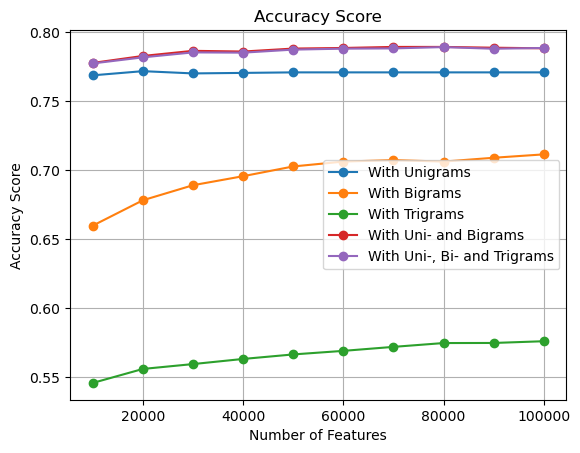

In [31]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from scipy.sparse import hstack

# Initialize CountVectorizer and LogisticRegression
cvec = CountVectorizer()
lr = LogisticRegression(random_state=42)

# Define different values for n_features
n_features = np.arange(10000, 100001, 10000)

# Initialize lists to store n_features and accuracy scores
n_features_list = []
accuracy_unigrams = []
accuracy_bigrams = []
accuracy_trigrams = []
accuracy_unibigrams = []
accuracy_unibitrigrams = []

# Loop through different values of n_features
for n in n_features:
   
    ### UNIGRAMS ###
    # Initialize CountVectorizer with max_features=n for unigrams
    cvec_unigrams = CountVectorizer(max_features=n, ngram_range=(1, 1))

    # Vectorize the string data for unigrams
    X_train_matrix_unigrams = cvec_unigrams.fit_transform(X_train['tweet_tokenized_string'])
    X_test_matrix_unigrams = cvec_unigrams.transform(X_test['tweet_tokenized_string'])

    # Fit the model and make predictions for unigrams
    lr.fit(X_train_matrix_unigrams, y_train)
    y_pred_unigrams = lr.predict(X_test_matrix_unigrams)
    accuracy_unigram = accuracy_score(y_test, y_pred_unigrams)
    accuracy_unigrams.append(accuracy_unigram)

    ### BIGRAMS ###
    # Initialize CountVectorizer with max_features=n for bigrams
    cvec_bigrams = CountVectorizer(max_features=n, ngram_range=(2, 2))

    # Vectorize the string data for bigrams
    X_train_matrix_bigrams = cvec_bigrams.fit_transform(X_train['tweet_tokenized_string'])
    X_test_matrix_bigrams = cvec_bigrams.transform(X_test['tweet_tokenized_string'])

    # Fit the model and make predictions for bigrams
    lr.fit(X_train_matrix_bigrams, y_train)
    y_pred_bigrams = lr.predict(X_test_matrix_bigrams)
    accuracy_bigram = accuracy_score(y_test, y_pred_bigrams)
    accuracy_bigrams.append(accuracy_bigram)

    ### TRIGRAMS ###
    # Create CountVectorizer with max_features=n for trigrams
    cvec_trigrams = CountVectorizer(max_features=n, ngram_range=(3, 3))

    # Vectorize the string data for trigrams
    X_train_matrix_trigrams = cvec_trigrams.fit_transform(X_train['tweet_tokenized_string'])
    X_test_matrix_trigrams = cvec_trigrams.transform(X_test['tweet_tokenized_string'])

    # Fit the model and make predictions for trigrams
    lr.fit(X_train_matrix_trigrams, y_train)
    y_pred_trigrams = lr.predict(X_test_matrix_trigrams)
    accuracy_trigram = accuracy_score(y_test, y_pred_trigrams)
    accuracy_trigrams.append(accuracy_trigram)

    ### UNIBIGRAMS ###
    # Initialize CountVectorizer with max_features=n for unibigrams
    cvec_unibigrams = CountVectorizer(max_features=n, ngram_range=(1, 2))

    # Vectorize the string data for unibigrams
    X_train_matrix_unibigrams = cvec_unibigrams.fit_transform(X_train['tweet_tokenized_string'])
    X_test_matrix_unibigrams = cvec_unibigrams.transform(X_test['tweet_tokenized_string'])

    # Fit the model and make predictions for unibigrams
    lr.fit(X_train_matrix_unibigrams, y_train)
    y_pred_unibigrams = lr.predict(X_test_matrix_unibigrams)
    accuracy_unibigram = accuracy_score(y_test, y_pred_unibigrams)
    accuracy_unibigrams.append(accuracy_unibigram)
    
    ### UNIBITRIGRAMS ###
    # Initialize CountVectorizer with max_features=n for unibitrigrams
    cvec_unibitrigrams = CountVectorizer(max_features=n, ngram_range=(1, 3))

    # Vectorize the string data for unibitrigrams
    X_train_matrix_unibitrigrams = cvec_unibitrigrams.fit_transform(X_train['tweet_tokenized_string'])
    X_test_matrix_unibitrigrams = cvec_unibitrigrams.transform(X_test['tweet_tokenized_string'])

    # Fit the model and make predictions for unibitrigrams
    lr.fit(X_train_matrix_unibitrigrams, y_train)
    y_pred_unibitrigrams = lr.predict(X_test_matrix_unibitrigrams)
    accuracy_unibitrigram = accuracy_score(y_test, y_pred_unibitrigrams)
    accuracy_unibitrigrams.append(accuracy_unibitrigram)

# Plot the accuracy scores
plt.plot(n_features, accuracy_unigrams, 'o-', label='With Unigrams')
plt.plot(n_features, accuracy_bigrams, 'o-', label='With Bigrams')
plt.plot(n_features, accuracy_trigrams, 'o-', label='With Trigrams')
plt.plot(n_features, accuracy_unibigrams, 'o-', label='With Uni- and Bigrams')
plt.plot(n_features, accuracy_unibitrigrams, 'o-', label='With Uni-, Bi- and Trigrams')
plt.xlabel('Number of Features')
plt.ylabel('Accuracy Score')
plt.title('Accuracy Score')
plt.legend()
plt.grid(True)
plt.show()

### 3. Linear Regression TF-IDF Vectorizer 

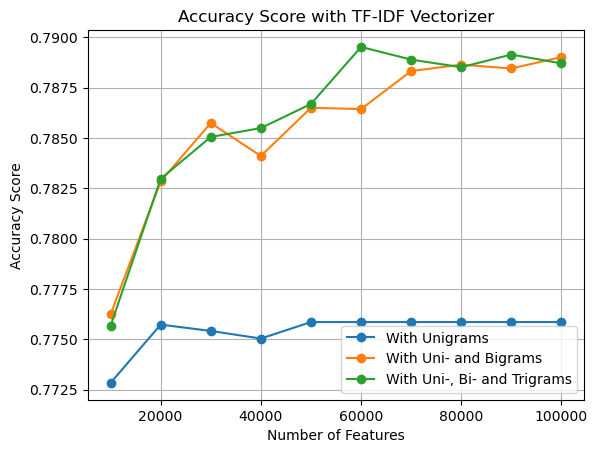

In [31]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

# Initialize and LogisticRegression
lr = LogisticRegression(random_state=42, n_jobs=-1)

# Define different values for n_features
n_features = np.arange(10000, 100001, 10000)

# Initialize lists to store n_features and accuracy scores
n_features_list = []
accuracy_tfidf_unigrams = []
accuracy_tfidf_unibigrams = []
accuracy_tfidf_unibitrigrams = []

# Loop through different values of n_features
for n in n_features:
   
    ### UNIGRAMS ###
    # Initialize CountVectorizer with max_features=n for unigrams
    tvec_unigrams = TfidfVectorizer(max_features=n, ngram_range=(1, 1))

    # Vectorize the string data for unigrams
    X_train_matrix_unigrams = tvec_unigrams.fit_transform(X_train['tweet_tokenized_string'])
    X_test_matrix_unigrams = tvec_unigrams.transform(X_test['tweet_tokenized_string'])

    # Fit the model and make predictions for unigrams
    lr.fit(X_train_matrix_unigrams, y_train)
    y_pred_unigrams = lr.predict(X_test_matrix_unigrams)
    accuracy_tfidf_unigram = accuracy_score(y_test, y_pred_unigrams)
    accuracy_tfidf_unigrams.append(accuracy_tfidf_unigram)

    ### UNIBIGRAMS ###
    # Initialize CountVectorizer with max_features=n for unibigrams
    tvec_unibigrams = TfidfVectorizer(max_features=n, ngram_range=(1, 2))

    # Vectorize the string data for unibigrams
    X_train_matrix_unibigrams = tvec_unibigrams.fit_transform(X_train['tweet_tokenized_string'])
    X_test_matrix_unibigrams = tvec_unibigrams.transform(X_test['tweet_tokenized_string'])

    # Fit the model and make predictions for unibigrams
    lr.fit(X_train_matrix_unibigrams, y_train)
    y_pred_unibigrams = lr.predict(X_test_matrix_unibigrams)
    accuracy_tfidf_unibigram = accuracy_score(y_test, y_pred_unibigrams)
    accuracy_tfidf_unibigrams.append(accuracy_tfidf_unibigram)
    
    ### UNIBITRIGRAMS ###
    # Initialize CountVectorizer with max_features=n for unibitrigrams
    tvec_unibitrigrams = TfidfVectorizer(max_features=n, ngram_range=(1, 3))

    # Vectorize the string data for unibitrigrams
    X_train_matrix_unibitrigrams = tvec_unibitrigrams.fit_transform(X_train['tweet_tokenized_string'])
    X_test_matrix_unibitrigrams = tvec_unibitrigrams.transform(X_test['tweet_tokenized_string'])

    # Fit the model and make predictions for unibitrigrams
    lr.fit(X_train_matrix_unibitrigrams, y_train)
    y_pred_unibitrigrams = lr.predict(X_test_matrix_unibitrigrams)
    accuracy_tfidf_unibitrigram = accuracy_score(y_test, y_pred_unibitrigrams)
    accuracy_tfidf_unibitrigrams.append(accuracy_tfidf_unibitrigram)

# Plot the accuracy scores
plt.plot(n_features, accuracy_tfidf_unigrams, 'o-', label='With Unigrams')
plt.plot(n_features, accuracy_tfidf_unibigrams, 'o-', label='With Uni- and Bigrams')
plt.plot(n_features, accuracy_tfidf_unibitrigrams, 'o-', label='With Uni-, Bi- and Trigrams')
plt.xlabel('Number of Features')
plt.ylabel('Accuracy Score')
plt.title('Accuracy Score with TF-IDF Vectorizer')
plt.legend()
plt.grid(True)
plt.show()

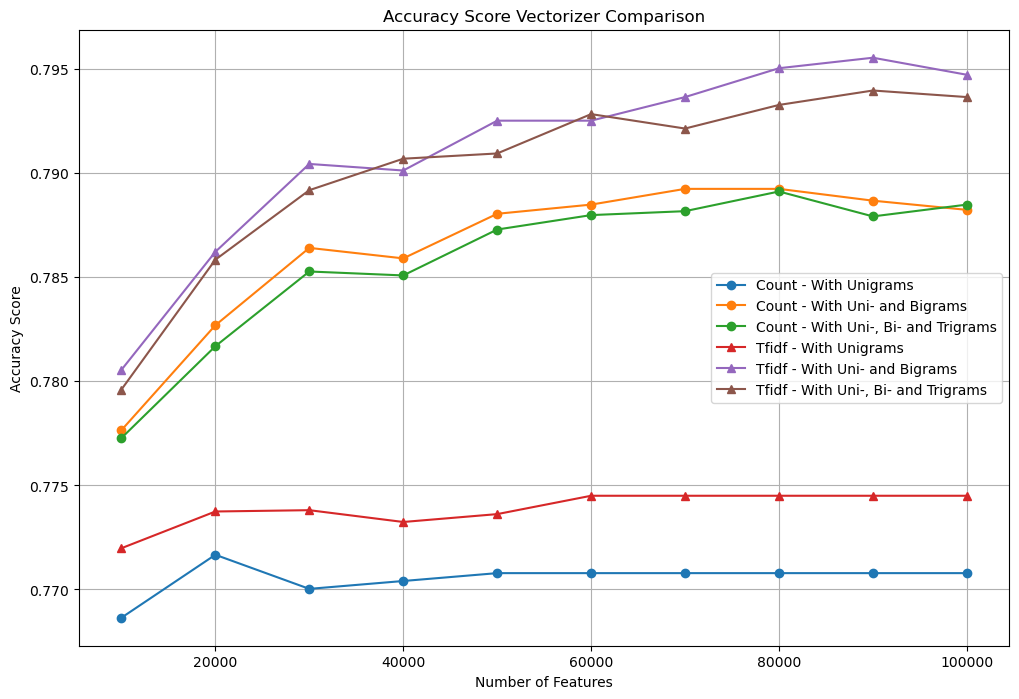

In [33]:
#Plot of accuracy scores from logreg with count vectorizer and tfidf vectorizer compared 
plt.figure(figsize=(12, 8))
plt.plot(n_features, accuracy_unigrams, 'o-', label='Count - With Unigrams')
plt.plot(n_features, accuracy_unibigrams, 'o-', label='Count - With Uni- and Bigrams')
plt.plot(n_features, accuracy_unibitrigrams, 'o-', label='Count - With Uni-, Bi- and Trigrams')
plt.plot(n_features, accuracy_tfidf_unigrams, '^-', label='Tfidf - With Unigrams')
plt.plot(n_features, accuracy_tfidf_unibigrams, '^-', label='Tfidf - With Uni- and Bigrams')
plt.plot(n_features, accuracy_tfidf_unibitrigrams, '^-', label='Tfidf - With Uni-, Bi- and Trigrams')
plt.xlabel('Number of Features')
plt.ylabel('Accuracy Score')
plt.title('Accuracy Score Vectorizer Comparison')
plt.legend()
plt.grid(True)
plt.show()

### 4. KNN-Classifier 

In [37]:
%pip install --upgrade scikit-learn numpy scipy

     ---------------------------------------- 15.1/15.1 MB 9.3 MB/s eta 0:00:00
     ---------------------------------------- 44.1/44.1 MB 8.4 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.22.4
    Uninstalling numpy-1.22.4:
      Successfully uninstalled numpy-1.22.4
Note: you may need to restart the kernel to use updated packages.


ERROR: Could not install packages due to an OSError: [WinError 5] Zugriff verweigert: 'C:\\Users\\ollin\\anaconda3\\Lib\\site-packages\\~umpy\\.libs\\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll'
Consider using the `--user` option or check the permissions.



In [38]:
from sklearn.neighbors import KNeighborsClassifier

# Initialize KNeighborsClassifier
knn = KNeighborsClassifier(n_jobs=-1)

# Define different values for n_features
n_features = np.arange(5000, 50001, 5000)

# Initialize lists to store n_features and accuracy scores
n_features_list = []
accuracy_knn_tfidf_unibigrams_5n = []
accuracy_knn_tfidf_unibigrams_50n = []

for n in n_features:

    ### UNIBIGRAMS 5 Neighbors###
    # Initialize CountVectorizer with max_features=n for unibigrams
    knn = KNeighborsClassifier(n_neighbors = 5, n_jobs=-1)
    tvec_unibigrams = TfidfVectorizer(max_features=n, ngram_range=(1, 2))

    # Vectorize the string data for unibigrams
    X_train_matrix_unibigrams = tvec_unibigrams.fit_transform(X_train['tweet_tokenized_string'])
    X_test_matrix_unibigrams = tvec_unibigrams.transform(X_test['tweet_tokenized_string'])

    # Fit the model and make predictions for unibigrams
    knn.fit(X_train_matrix_unibigrams, y_train)
    y_pred_unibigrams = knn.predict(X_test_matrix_unibigrams)
    accuracy_knn_tfidf_unibigram = accuracy_score(y_test, y_pred_unibigrams)
    accuracy_knn_tfidf_unibigrams_5n.append(accuracy_knn_tfidf_unibigram)

    ### UNIBIGRAMS 50 Neighbors###
    # Initialize CountVectorizer with max_features=n for unibigrams
    knn = KNeighborsClassifier(n_neighbors = 50, n_jobs=-1)
    tvec_unibigrams = TfidfVectorizer(max_features=n, ngram_range=(1, 2))

    # Vectorize the string data for unibigrams
    X_train_matrix_unibigrams = tvec_unibigrams.fit_transform(X_train['tweet_tokenized_string'])
    X_test_matrix_unibigrams = tvec_unibigrams.transform(X_test['tweet_tokenized_string'])

    # Fit the model and make predictions for unibigrams
    knn.fit(X_train_matrix_unibigrams, y_train)
    y_pred_unibigrams = knn.predict(X_test_matrix_unibigrams)
    accuracy_knn_tfidf_unibigram = accuracy_score(y_test, y_pred_unibigrams)
    accuracy_knn_tfidf_unibigrams_50n.append(accuracy_knn_tfidf_unibigram)

plt.plot(n_features, accuracy_knn_tfidf_unibigrams_5n, 's-', label='KNN with Uni- and Bigrams (5 Neighbors)')
plt.plot(n_features, accuracy_knn_tfidf_unibigrams_50n, 's-', label='KNN with Uni- and Bigrams (50 Neighbors))')
plt.xlabel('Number of Features')
plt.ylabel('Accuracy Score')
plt.title('Accuracy Score KNN')
plt.legend()
plt.grid(True)
plt.show()

AttributeError: 'NoneType' object has no attribute 'split'

### 5. Neural Network

In [39]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import Flatten
from keras.layers import Embedding
from keras.preprocessing import sequence

In [40]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Initialize lists to store n_features and accuracy scores
accuracy_neuralnet_tfidf_unibitrigrams = []

tvec = TfidfVectorizer(max_features= 200000,ngram_range=(1, 3))

#Vectorize String
X_train_matrix = tvec.fit_transform(X_train['tweet_tokenized_string'])
X_validation_matrix = tvec.transform(X_validation['tweet_tokenized_string'])
X_test_matrix = tvec.transform(X_test['tweet_tokenized_string'])


# Define a generator to yield batches of sparse input data
def sparse_batch_generator(X_data, y_data, batch_size):
    samples_per_epoch = X_data.shape[0]
    number_of_batches = samples_per_epoch // batch_size
    counter = 0
    index = np.arange(samples_per_epoch)
    while True:
        index_batch = index[batch_size * counter:batch_size * (counter + 1)]
        X_batch = X_data[index_batch].toarray()  # Convert SparseTensor to dense matrix
        X_batch = np.reshape(X_batch, (X_batch.shape[0], -1))
        y_batch = np.array(y_data.iloc[index_batch]).reshape(-1, 1)
        counter += 1
        yield (X_batch, y_batch)
        if counter >= number_of_batches:
            counter = 0



# Define the architecture of your neural network model
model = Sequential()
model.add(Dense(64, activation='relu', input_dim=X_train_matrix.shape[1]))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model using the sparse batch generator
model.fit(sparse_batch_generator(X_train_matrix, y_train, batch_size=32),
          steps_per_epoch=X_train_matrix.shape[0] // 32,
          epochs=5,
          validation_data=sparse_batch_generator(X_validation_matrix, y_validation, batch_size=32),
          validation_steps=X_validation_matrix.shape[0] // 32)

# Evaluate the model on the test data
loss, accuracy = model.evaluate(sparse_batch_generator(X_test_matrix, y_test, batch_size=32),
                                          steps=X_test_matrix.shape[0] // 32)

accuracy_nn = accuracy
accuracy_neuralnet_tfidf_unibitrigrams.append(accuracy_nn)

print('Test Loss:', loss)
print('Test Accuracy:', accuracy_nn)

Epoch 1/5
44650/44650 [==============================] - 6097s 136ms/step - loss: 0.4583 - accuracy: 0.7827 - val_loss: 0.4460 - val_accuracy: 0.7899
Epoch 2/5
44650/44650 [==============================] - 6493s 145ms/step - loss: 0.4144 - accuracy: 0.8108 - val_loss: 0.4506 - val_accuracy: 0.7888
Epoch 3/5
44650/44650 [==============================] - 6741s 151ms/step - loss: 0.3949 - accuracy: 0.8228 - val_loss: 0.4646 - val_accuracy: 0.7841
Epoch 4/5
44650/44650 [==============================] - 5898s 132ms/step - loss: 0.3635 - accuracy: 0.8407 - val_loss: 0.5019 - val_accuracy: 0.7708
Epoch 5/5
496/496 [==============================] - 14s 29ms/step - loss: 0.5268 - accuracy: 0.7635
Test Loss: 0.5268347859382629
Test Accuracy: 0.7635458707809448


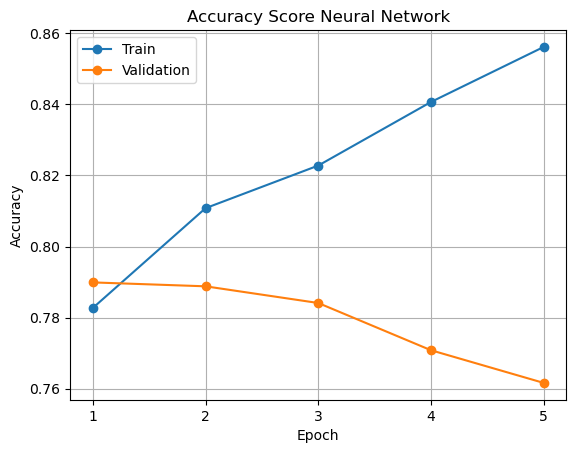

In [49]:
accuracy_train = { 1: 0.7827, 2 : 0.8108, 3 : 0.8228, 4 : 0.8407, 5 : 0.8562}
accuracy_val = {1 : 0.7899, 2 : 0.7888, 3 : 0.7841, 4 : 0.7708, 5 : 0.7616}

plt.plot(list(accuracy_train.keys()),list(accuracy_train.values()), marker = 'o')
plt.plot(list(accuracy_val.keys()),list(accuracy_val.values()), marker = "o")
plt.title('Accuracy Score Neural Network')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.grid(True)
plt.xticks(range(int(min(list(accuracy_train.keys()))), int(max(list(accuracy_train.keys()))) + 1))
plt.show()

## Model Evaluation

In [ ]:
# Create a list with all the accuracies per feature amount
accuracy_lists = [accuracy_unibigrams, accuracy_unibitrigrams, accuracy_tfidf_unibigrams, accuracy_tfidf_unibitrigrams, accuracy_tfidf_unibigrams_100k, accuracy_knn_tfidf_unibigrams_5n, accuracy_knn_tfidf_unibigrams_50n]
accuracy_lists_names = ['accuracy_unibigrams', 'accuracy_unibitrigrams', 'accuracy_tfidf_unibigrams', 'accuracy_tfidf_unibitrigrams', 'accuracy_tfidf_unibigrams_100k', 'accuracy_knn_tfidf_unibigrams_5n', 'accuracy_knn_tfidf_unibigrams_50n']

# Create an empty DataFrame
df = pd.DataFrame(columns=['Model', 'Max Acc Value', 'Features'])

# Iterate over the lists to create dataframe with all the best accuracies and its feature amounts
for list_index, lst in enumerate(accuracy_lists):
    max_value = max(lst)
    if accuracy_lists_names[list_index] == 'accuracy_tfidf_unibigrams_100k':
            max_position = 40000 + (lst.index(max_value)+1)*10000
    else:   max_position = (lst.index(max_value)+1)*10000
    df = df.append({'Model': accuracy_lists_names[list_index], 'Max Acc Value': max_value, 'Features': max_position},
                   ignore_index=True)
    
#add neural_network
df = df.append({'Model': 'accuracy_neuralnet_tfidf_unibitrigrams', 'Max Acc Value': accuracy_nn, 'Features': 200000})

# Print the DataFrame
display(df)

C:\Users\Dave\AppData\Local\Temp\ipykernel_29804\372124947.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Model': accuracy_lists_names[list_index], 'Max Acc Value': max_value, 'Features': max_position},
C:\Users\Dave\AppData\Local\Temp\ipykernel_29804\372124947.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Model': accuracy_lists_names[list_index], 'Max Acc Value': max_value, 'Features': max_position},
C:\Users\Dave\AppData\Local\Temp\ipykernel_29804\372124947.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Model': accuracy_lists_names[list_index], 'Max Acc Value': max_value, 'Features': max_position},
C:\Users\Dave\AppData\Local\Temp\ipykernel_29804\372124

,Model,Max Acc Value,Features
0,accuracy_unibigrams,0.788045,50000
1,accuracy_unibitrigrams,0.787667,45000
2,accuracy_tfidf_unibigrams,0.792517,50000
3,accuracy_tfidf_unibitrigrams,0.791572,50000
4,accuracy_tfidf_unibigrams_100k,0.795729,90000
5,accuracy_knn_tfidf_unibigrams_5n,0.677249,5000
6,accuracy_knn_tfidf_unibigrams_50n,0.677564,15000


### Look at Classification for random tweets to sense check

In [30]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

# Initialize and LogisticRegression
lr = LogisticRegression(random_state=42, n_jobs=-1)

# Define different values for n_features
n_features = np.arange(10000, 100001, 10000)

   
### UNI-BIGRAMS ###
# Initialize CountVectorizer with max_features=n for uni-bigrams
tvec_unibigrams = TfidfVectorizer(max_features=90000, ngram_range=(1, 2))

# Vectorize the string data for unigrams
X_train_matrix_unibigrams = tvec_unibigrams.fit_transform(X_train['tweet_tokenized_string'])
X_test_matrix_unibigrams = tvec_unibigrams.transform(X_test['tweet_tokenized_string'])

# Fit the model and make predictions for unigrams
lr.fit(X_train_matrix_unibigrams, y_train)
y_pred_unibigrams = lr.predict(X_test_matrix_unibigrams)
accuracy = accuracy_score(y_test, y_pred_unibigrams)
print ("accuracy score: {0:.2f}%".format(accuracy*100))

accuracy score: 78.85%


In [32]:
results_df = pd.DataFrame({'Tweet': X_test['tweet_tokenized_string'], 'Score': y_pred_unibigrams})

# Sort the dataframe in descending order by score
results_df = results_df.sort_values(by='Classification/Score', ascending=False)

# Reset the index of the dataframe
results_df = results_df.reset_index(drop=True)

results_df

KeyError: 'Classification/Score'

## Train best model with full dataset

In [50]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

# Initialize and LogisticRegression
lr_best = LogisticRegression(random_state=42, n_jobs=-1)

### UNIBIGRAMS ###
# Initialize CountVectorizer with max_features=n for unibigrams
tvec_unibigrams = TfidfVectorizer(max_features=90000, ngram_range=(1, 2))

# Vectorize the string data for unibigrams
X_matrix_unibigrams = tvec_unibigrams.fit_transform(X['tweet_tokenized_string'])

# Fit the model and make predictions for unibigrams
lr_best.fit(X_matrix_unibigrams, y)

LogisticRegression(n_jobs=-1, random_state=42)

## Twitter Scraper

In [14]:
# Define search parameters
text = "#starbucks"     # Search term or hashtag
year_from = 2019        # Starting year of seach
year_until = 2023       # End year of search 
count = 5000               # Tweets per month

# Define function to input search parameters in scraper
def search(text, since, until): 
    global filename
    q = text
    since = since.strftime("%Y-%m-%d")
    until = until.strftime("%Y-%m-%d")
    q += f" since:{since}" 
    q += f" until:{until}" 
    filename = f"{year_from}_to_{year_until}_{text}.csv"
    return q

In [15]:
# Empty list to fill tweets in
tweets = []

# Loop through different years
for year in range(year_from, year_until + 1):
    # Loop through different months
    for month in range(1, 13):

        # Define search period (first to last day of respective month)
        since = pd.to_datetime(f"{year}-{month:02d}-01")
        until = pd.to_datetime(f"{year}-{month:02d}-01") + pd.offsets.MonthEnd()        

        # Break loop if it exceeds todays date (as there won't be any more tweets)
        if until > pd.Timestamp.today():
            break

        # Set Twitter scraper up
        q = search(text,since,until)    # Search parameters for respective year and months
        scraper = sntwitter.TwitterSearchScraper(q)

        # Dummy variable to count number of tweets per month
        b = 0

        # Loop that extracts individual tweets
        for tweet in scraper.get_items():
            data = [
                tweet.date, 
                tweet.id, 
                tweet.content, 
                tweet.user.username, 
                tweet.likeCount, 
                tweet.retweetCount
            ]

            # Break loop if number of tweets per month is reached
            if b > count - 1:
                break

            # Only add english tweets to list    
            if tweet.lang == "en": 
                tweets.append(data)
                b += 1

# Store the scraped tweets in a DataFrame               
tweet_df = pd.DataFrame(
    tweets, columns = ["date", "id", "content", "username", "like_count", "retweet_count"]
)

# Store the scraped tweets in a csv
tweet_df.to_csv(f"{filename}",index=False)

C:\Users\del-f\AppData\Local\Temp\ipykernel_16308\11489748.py:29: DeprecatedFeatureWarning: content is deprecated, use rawContent instead
  tweet.content,
Unavailable user in card on tweet 1087409518278033409
User 1667612219654262789 not found in user refs in card on tweet 1087409518278033409
Unavailable user in card on tweet 1099435507153391621
User 1667612219654262789 not found in user refs in card on tweet 1099435507153391621
Unavailable user in card on tweet 1098325806504337408
User 1667612219654262789 not found in user refs in card on tweet 1098325806504337408
Empty user ref object in card on tweet 1095012277504356357
User 899733078641225728 not found in user refs in card on tweet 1095012277504356357
Unavailable user in card on tweet 1111508886811480064
User 1667612219654262789 not found in user refs in card on tweet 1111508886811480064
Unavailable user in card on tweet 1111331599281319936
User 1667612219654262789 not found in user refs in card on tweet 1111331599281319936
Unavail

## Prepare Scraped Tweets

### Read Scraped Tweets

In [124]:
#Prepare files to be read
file_names = ['../Data/2019_to_2023_#starbucks.csv', '../Data/2019_to_2023_#BurgerKing.csv', '../Data/2019_to_2023_#McDonalds.csv'] 
#Prepare names for dataframes
data_names = ['starbucks', 'burgerking', 'mcdonalds']
#Create dictionary to store dataframes
dataframes = {}
dataframes_dates = {}
for i in range(len(data_names)):
    scraped = pd.read_csv(file_names[i], encoding='latin-1')
    scraped['date'] = pd.to_datetime(scraped['date'])
    scraped['year'] = scraped['date'].dt.year
    scraped['year-month'] = scraped['date'].dt.strftime('%Y-%m')
    scraped = scraped.drop(['date', 'id', 'username', 'like_count', 'retweet_count'], axis=1)
    dataframes[data_names[i]] = scraped #-> dataframes[data_names[0]] = Starbucks


### URL, #, @, links, emojis

In [125]:
#Define the typical pattern of links ('https://', 'http://', 'www.'), tags ('@') and hashtags ('#')
url_pattern_1 = r'https?://\S+'
url_pattern_2 = r'www\.\S+'
tag_pattern = r'@\S+'
hashtag_pattern = r'#\S+'

# Function for converting emojis into word
def convert_emoticons(text):
    for emot in EMOTICONS_EMO:
        text = text.replace(emot, "".join(EMOTICONS_EMO[emot].replace(",","").replace(":","").split()))
    return text

#Add a new column for the tokenized tweet and remove all links, tags, hashtags and emojis from the tweets
for i in range(len(data_names)):
    scraped = dataframes[data_names[i]]
    scraped.insert(1, 'tweet_tokenized', scraped['content'].apply(lambda x: re.sub(url_pattern_1, '', x)))
    scraped['tweet_tokenized'] = scraped['tweet_tokenized'].apply(lambda x: re.sub(url_pattern_2, '', x))
    scraped['tweet_tokenized'] = scraped['tweet_tokenized'].apply(lambda x: re.sub(tag_pattern, '', x))
    scraped['tweet_tokenized'] = scraped['tweet_tokenized'].apply(lambda x: re.sub(hashtag_pattern, '', x))
    scraped['tweet_tokenized'] = scraped['tweet_tokenized'].apply(lambda x: convert_emoticons(x))
    dataframes[data_names[i]] = scraped

### Punctuation, Whitespace, Lowercase, Numbers

In [126]:
for i in range(len(data_names)):
    scraped = dataframes[data_names[i]]
    scraped['tweet_tokenized'] = scraped['tweet_tokenized'].str.replace('[^\w\s]', ' ')     #Remove all punctuation from the tweets
    scraped['tweet_tokenized'] = scraped['tweet_tokenized'].str.replace('_', '')            #Remove all underscores from the tweets
    scraped['tweet_tokenized'] = scraped['tweet_tokenized'].str.strip()                     #Remove all whitespaces from the beginning or end of the tweets
    scraped['tweet_tokenized'] = scraped['tweet_tokenized'].apply(lambda x: x.lower())      #Set all characters to lowercase
    scraped['tweet_tokenized'] = scraped['tweet_tokenized'].str.replace('\d+', '')          #Remove all numbers
    dataframes[data_names[i]] = scraped

C:\Users\del-f\AppData\Local\Temp\ipykernel_11232\4244730734.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  scraped['tweet_tokenized'] = scraped['tweet_tokenized'].str.replace('[^\w\s]', ' ')     #Remove all punctuation from the tweets
C:\Users\del-f\AppData\Local\Temp\ipykernel_11232\4244730734.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
  scraped['tweet_tokenized'] = scraped['tweet_tokenized'].str.replace('\d+', '')          #Remove all numbers


### Tokenizing

In [127]:
def tokenize(text):
    tokens = re.split('\W+', text)
    return tokens

#Tokenize sentences based on non-alphanumeric characters (Leerstelle)
for i in range(len(data_names)):
    scraped = dataframes[data_names[i]]
    scraped['tweet_tokenized'] = scraped['tweet_tokenized'].apply(lambda x: tokenize(x))
    dataframes[data_names[i]] = scraped

### Remove Stopwords

In [128]:
#nltk.download('stopwords')
stopword = nltk.corpus.stopwords.words('english') #Create a list of english stopwords from nltk
stopword_clean = [word.replace("'", "") for word in stopword]

In [129]:
def remove_stopwords(tokenized_list): #Function to remove all stopword from our list of tokenized tweets
    text = [word for word in tokenized_list if word not in stopword_clean] #Write each word from our tokenized list into a new list, if it is not in the stopword list
    return text

#Create new column with tokenized tweets without stopwords
for i in range(len(data_names)):
    scraped = dataframes[data_names[i]]
    scraped['tweet_tokenized'] = scraped['tweet_tokenized'].apply(lambda x: remove_stopwords(x)) 
    dataframes[data_names[i]] = scraped

### Lemmatizing

In [130]:
#nltk.download('wordnet')
wnlemm = nltk.WordNetLemmatizer() 

def lemmatizing(tokenized_text): #Function to lemmatize all words in our tokenized tweets list without stopwords
    text = [wnlemm.lemmatize(word) for word in tokenized_text] #Lemmatize each word in our tokenized list and write it into a new list
    return text

for i in range(len(data_names)):
    scraped = dataframes[data_names[i]]
    scraped['tweet_tokenized'] = scraped['tweet_tokenized'].apply(lambda x: lemmatizing(x))
    dataframes[data_names[i]] = scraped

### Convert Tokenized List to String

In [131]:
#N-gram vectorizing and tfidf need a list of strings passed to it, so we need to convert our list
for i in range(len(data_names)):
    scraped = dataframes[data_names[i]]
    scraped['tweet_tokenized_string'] = scraped['tweet_tokenized'].apply(lambda x: ' '.join(x)) #Join each word in our list with a space inbetween
    dataframes[data_names[i]] = scraped

In [132]:
dataframes[data_names[0]]

,content,tweet_tokenized,year,year-month,tweet_tokenized_string
0,Hot chocolate run. âï¸ #Starbucks #heinebro...,"[hot, chocolate, run, â, ï]",2019,2019-01,hot chocolate run â ï
1,#Democrats Trying to Buy Votes with Big Spendi...,"[trying, buy, vote, big, spending, warns]",2019,2019-01,trying buy vote big spending warns
2,Easy peasy...dump #Starbucks stock and tank it...,"[easy, peasy, dump, stock, tank, funding, camp...",2019,2019-01,easy peasy dump stock tank funding campaign fo...
3,Ready to get my work night started. From the ...,"[ready, get, work, night, started, entrepreneu...",2019,2019-01,ready get work night started entrepreneur grin...
4,Hmmmm.... saw this parked outside of #Starbuck...,"[hmmmm, saw, parked, outside, look, bone, tire...",2019,2019-01,hmmmm saw parked outside look bone tired date ...
...,...,...,...,...,...
212780,"Starbucks' Ice Policy, Explained - Mashed #Sta...","[starbucks, ice, policy, explained, mashed]",2023,2023-05,starbucks ice policy explained mashed
212781,$SBUX vs. $WING: what will be the best investm...,"[sbux, v, wing, best, investment]",2023,2023-05,sbux v wing best investment
212782,Surprised my mom with Starbucks and flowers ð...,"[surprised, mom, starbucks, flower, ð, ð, ¼]",2023,2023-05,surprised mom starbucks flower ð ð ¼
212783,Looking for #bookish deals? Our #Fantasy &amp;...,"[looking, deal, amp, book, fair, free, discoun...",2023,2023-05,looking deal amp book fair free discounted boo...


So sind die DataFrames gespeichert:

#dataframes[data_names[0]] == starbucks

#dataframes[data_names[1]] == burgerking

#dataframes[data_names[2]] == mcdonalds

### Vectorizing

In [133]:
#Train best model with full dataset has to have happened before this step

#Create empty dictionary to store matrices
matrices = {}

#Vectorize each dataframe resulting in 3 matrices
for i in range(len(data_names)):
    matrix = tvec_unibigrams.transform(dataframes[data_names[i]]['tweet_tokenized_string'])
    matrices[data_names[i]] = matrix


In [134]:
starbucks_matrix = matrices[data_names[0]]
burgerking_matrix = matrices[data_names[1]]
mcdonalds_matrix = matrices[data_names[2]]

### Predicting Scraped Tweet Sentiment

In [135]:
pred_starbucks = lr_best.predict(starbucks_matrix)
pred_proba_starbucks = lr_best.predict_proba(starbucks_matrix)

pred_burgerking = lr_best.predict(burgerking_matrix)
pred_proba_burgerking = lr_best.predict_proba(burgerking_matrix)

pred_mcdonalds = lr_best.predict(mcdonalds_matrix)
pred_proba_mcdonalds = lr_best.predict_proba(mcdonalds_matrix)

## Combining Tweets with prediction

In [136]:
starbucks = dataframes[data_names[0]]
burgerking = dataframes[data_names[1]]
mcdonalds = dataframes[data_names[2]]

In [137]:
starbucks['prediction'] = pred_starbucks
starbucks['prediction_proba_neg'] = pred_proba_starbucks[:, 0]
starbucks['prediction_proba_pos'] = pred_proba_starbucks[:, 1]

burgerking['prediction'] = pred_burgerking
burgerking['prediction_proba_neg'] = pred_proba_burgerking[:, 0]
burgerking['prediction_proba_pos'] = pred_proba_burgerking[:, 1]

mcdonalds['prediction'] = pred_mcdonalds
mcdonalds['prediction_proba_neg'] = pred_proba_mcdonalds[:, 0]
mcdonalds['prediction_proba_pos'] = pred_proba_mcdonalds[:, 1]

In [138]:
starbucks.head()

,content,tweet_tokenized,year,year-month,tweet_tokenized_string,prediction,prediction_proba_neg,prediction_proba_pos
0,Hot chocolate run. âï¸ #Starbucks #heinebro...,"[hot, chocolate, run, â, ï]",2019,2019-01,hot chocolate run â ï,1,0.297228,0.702772
1,#Democrats Trying to Buy Votes with Big Spendi...,"[trying, buy, vote, big, spending, warns]",2019,2019-01,trying buy vote big spending warns,0,0.665299,0.334701
2,Easy peasy...dump #Starbucks stock and tank it...,"[easy, peasy, dump, stock, tank, funding, camp...",2019,2019-01,easy peasy dump stock tank funding campaign fo...,0,0.524810,0.475190
3,Ready to get my work night started. From the ...,"[ready, get, work, night, started, entrepreneu...",2019,2019-01,ready get work night started entrepreneur grin...,1,0.258611,0.741389
4,Hmmmm.... saw this parked outside of #Starbuck...,"[hmmmm, saw, parked, outside, look, bone, tire...",2019,2019-01,hmmmm saw parked outside look bone tired date ...,1,0.432859,0.567141


## Analyze results

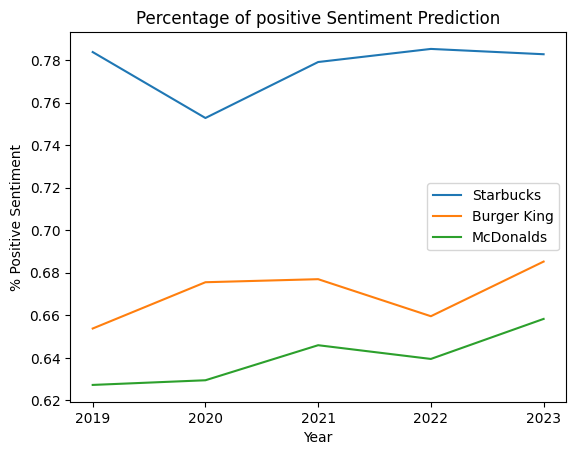

In [164]:
average_values_starbucks = pd.DataFrame(starbucks.groupby('year')['prediction'].mean())
average_values_burgerking = pd.DataFrame(burgerking.groupby('year')['prediction'].mean())
average_values_mcdonalds = pd.DataFrame(mcdonalds.groupby('year')['prediction'].mean())

# Create a new figure and axis
fig, ax = plt.subplots()

# Plot each dataframe on the same axis
ax.plot(average_values_starbucks.index, average_values_starbucks['prediction'], label='Starbucks')
ax.plot(average_values_burgerking.index, average_values_burgerking['prediction'], label='Burger King')
ax.plot(average_values_mcdonalds.index, average_values_mcdonalds['prediction'], label='McDonalds')

# Add labels and title to the plot
ax.set_xlabel('Year')
ax.set_ylabel('% Positive Sentiment')
ax.set_title('Percentage of positive Sentiment Prediction')

# Add a legend
ax.legend()

# Formatting x-axis ticks to display only full numbers
plt.xticks(average_values_starbucks.index)

# Display the plot
plt.show()

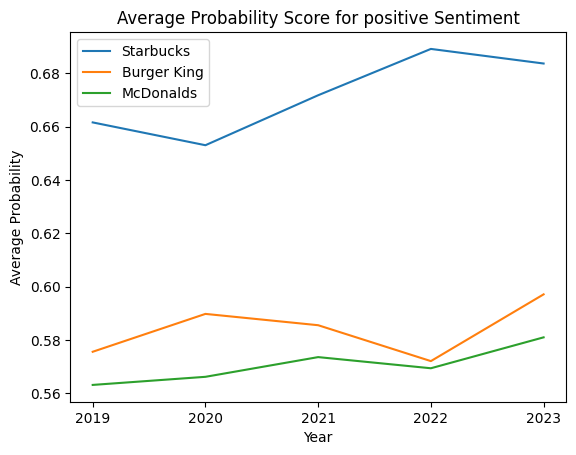

In [163]:
average_values_starbucks = pd.DataFrame(starbucks.groupby('year')['prediction_proba_pos'].mean())
average_values_burgerking = pd.DataFrame(burgerking.groupby('year')['prediction_proba_pos'].mean())
average_values_mcdonalds = pd.DataFrame(mcdonalds.groupby('year')['prediction_proba_pos'].mean())

# Create a new figure and axis
fig, ax = plt.subplots()

# Plot each dataframe on the same axis
ax.plot(average_values_starbucks.index, average_values_starbucks['prediction_proba_pos'], label='Starbucks')
ax.plot(average_values_burgerking.index, average_values_burgerking['prediction_proba_pos'], label='Burger King')
ax.plot(average_values_mcdonalds.index, average_values_mcdonalds['prediction_proba_pos'], label='McDonalds')

# Add labels and title to the plot
ax.set_xlabel('Year')
ax.set_ylabel('Average Probability')
ax.set_title('Average Probability Score for positive Sentiment')

# Add a legend
ax.legend()

# Formatting x-axis ticks to display only full numbers
plt.xticks(average_values_starbucks.index)

# Display the plot
plt.show()

In [154]:
# Create dataframe with ACSI Scores as reference
acsi_scores = pd.DataFrame({
    'Year': [2019, 2020, 2021, 2022],
    'Starbucks': [79, 78, 79, 77],      # https://www.statista.com/statistics/216719/starbucks--customer-satisfaction-in-the-us/
    'Burger King': [76, 76, 76, 75],    # https://www.statista.com/statistics/216692/burger-king--customer-satisfaction-in-the-us/
    'Mc Donalds': [69, 70, 70, 68]      # https://www.statista.com/statistics/216696/mcdonalds--customer-satisfaction-in-the-us/
}).set_index('Year')

acsi_scores

,Starbucks,Burger King,Mc Donalds
Year,,,
2019,79,76,69
2020,78,76,70
2021,79,76,70
2022,77,75,68


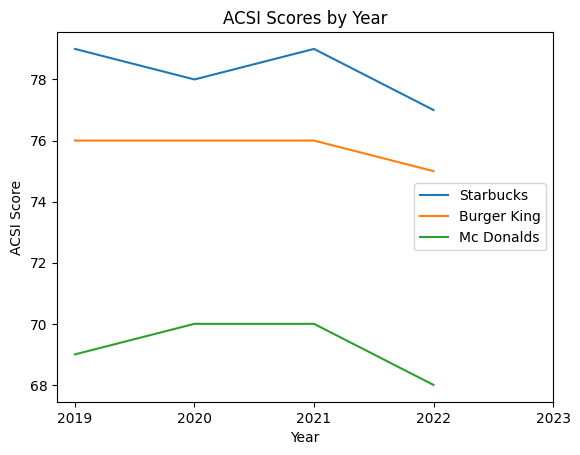

In [157]:
# Plotting a bar plot
acsi_scores.plot()

# Adding labels and title
plt.xlabel('Year')
plt.ylabel('ACSI Score')
plt.title('ACSI Scores by Year')

# Formatting x-axis ticks to display only full numbers
plt.xticks(average_values_starbucks.index)

# Displaying the plot
plt.show()